# Apple Stock

### Introduction:

We are going to use Apple's stock price.


### Step 1. Import the necessary libraries

In [ ]:
using DotEnv
using Pkg

DotEnv.load!()
path = ENV["ENV_PATH"]
Pkg.activate(path)

using CSV
using Dates
using Plots
using Downloads
using Statistics
using DataFrames

### Step 2. Import the dataset from this [address](https://raw.githubusercontent.com/guipsamora/pandas_exercises/master/09_Time_Series/Apple_Stock/appl_1980_2014.csv)

In [2]:
url = "https://raw.githubusercontent.com/guipsamora/pandas_exercises/master/09_Time_Series/Apple_Stock/appl_1980_2014.csv"
file = Downloads.download(url);

### Step 3. Assign it to a variable apple

In [3]:
apple = CSV.read(file, DataFrame)

first(apple, 5)

Row,Date,Open,High,Low,Close,Volume,Adj Close
,Date,Float64,Float64,Float64,Float64,Int64,Float64
1,2014-07-08,96.27,96.8,93.92,95.35,65130000,95.35
2,2014-07-07,94.14,95.99,94.1,95.97,56305400,95.97
3,2014-07-03,93.67,94.1,93.2,94.03,22891800,94.03
4,2014-07-02,93.87,94.06,93.09,93.48,28420900,93.48
5,2014-07-01,93.52,94.07,93.13,93.52,38170200,93.52


### Step 4.  Check out the type of the columns

In [4]:
for col in names(apple)
    type = eltype(apple[!, col])
    println("Column $col with type $(type)")
end

Column Date with type Date
Column Open with type Float64
Column High with type Float64
Column Low with type Float64
Column Close with type Float64
Column Volume with type Int64
Column Adj Close with type Float64


### Step 5. Transform the Date column as a datetime type

In [5]:
apple[!, "Date"] = Date.(apple[!, "Date"]);

### Step 6.  Is there any duplicate dates?

In [6]:
function has_duplicates(arr)
    set_arr = Set(arr)
    return length(set_arr) < length(arr)
end

has_duplicates(apple[!, "Date"])

false

### Step 7.  Ops...it seems the index is from the most recent date. Make the first entry the oldest date.

In [7]:
apple = sort(apple, :Date, rev=false)
first(apple, 5)

Row,Date,Open,High,Low,Close,Volume,Adj Close
,Date,Float64,Float64,Float64,Float64,Int64,Float64
1,1980-12-12,28.75,28.87,28.75,28.75,117258400,0.45
2,1980-12-15,27.38,27.38,27.25,27.25,43971200,0.42
3,1980-12-16,25.37,25.37,25.25,25.25,26432000,0.39
4,1980-12-17,25.87,26.0,25.87,25.87,21610400,0.4
5,1980-12-18,26.63,26.75,26.63,26.63,18362400,0.41


### Step 8. Get the last business day of each month

In [8]:
function is_business_day(date::Date)
    day_of_week = Dates.dayofweek(date)
    return day_of_week in 1:5 # Monday to Friday are considered business days
end

# Function to get the last business day of a month
function last_business_day(year::Int, month::Int)
    last_day = Dates.lastdayofmonth(Date(year, month, 1))
    while !is_business_day(last_day)
        last_day -= Day(1)
    end
    return last_day
end

# Add a year and month column for grouping
apple.Year = year.(apple.Date)
apple.Month = month.(apple.Date)

# Group by year and month
grouped = groupby(apple, [:Year, :Month])

# For each group, find the last business day and calculate the mean price
results = combine(grouped) do df
    last_bd = last_business_day(df.Year[1], df.Month[1])
    last_row = df[df.Date .== last_bd, :]
    DataFrame(
        LastBD = last_bd, 
        Open = mean(df.Open),
        High = mean(df.High),
        Low = mean(df.Low),
        Close = mean(df.Close),
        Volume = mean(df.Volume),
        AdjClose = mean(df[!, "Adj Close"])
    )
end

first(results, 10)

Row,Year,Month,LastBD,Open,High,Low,Close,Volume,AdjClose
,Int64,Int64,Date,Float64,Float64,Float64,Float64,Float64,Float64
1,1980,12,1980-12-31,30.4815,30.5677,30.4431,30.4431,2.58625e7,0.473077
2,1981,1,1981-01-30,31.7548,31.8267,31.6548,31.6548,7.24987e6,0.49381
3,1981,2,1981-02-27,26.48,26.5721,26.4079,26.4079,4.23183e6,0.411053
4,1981,3,1981-03-31,24.9377,25.0168,24.8364,24.8364,7.96269e6,0.387727
5,1981,4,1981-04-30,27.2867,27.3681,27.2271,27.2271,6.392e6,0.423333
6,1981,5,1981-05-29,29.052,29.188,28.995,28.995,7.38024e6,0.4525
7,1981,6,1981-06-30,30.8018,30.8764,30.7036,30.7036,1.08019e7,0.477727
8,1981,7,1981-07-31,24.4364,24.5318,24.3745,24.3745,7.58444e6,0.379545
9,1981,8,1981-08-31,22.3365,22.3865,22.2185,22.2185,6.85776e6,0.345


### Step 9.  What is the difference in days between the first day and the oldest

In [9]:
max_date = maximum(apple[!, "Date"])
min_date =  minimum(apple[!, "Date"])

max_date - min_date

12261 days

### Step 10.  How many months in the data we have?

In [10]:
how_many_year = Year(max_date) - Year(min_date)
max_month = Dates.Month(max_date)
min_month = Dates.Month(min_date)
month_diff = max_month - min_month

n_year = how_many_year.value * 12 + month_diff.value

403

### Step 11. Plot the 'Adj Close' value. Set the size of the figure to 13.5 x 9 inches

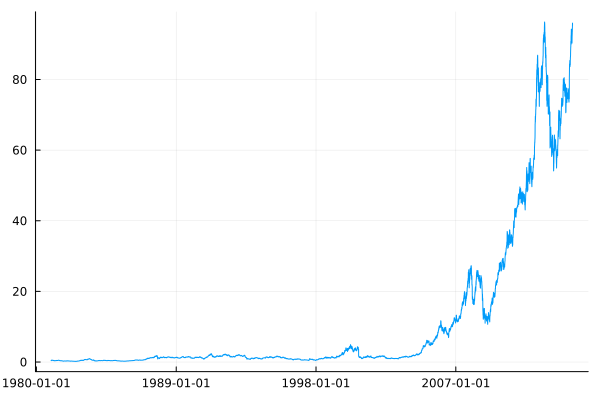

In [17]:
plot(apple[!, "Date"], apple[!, "Adj Close"], legend=false)

### BONUS: Create your own question and answer it.